In [6]:

import numpy as np
import matplotlib.pyplot as plt


# ------------------------ helpers ------------------------ #

def randsafe(s: int) -> float:
    """
    Python translation of the MATLAB randsafe(s) helper.
    """
    r = np.random.rand()
    is_ = 0
    while is_ < s:
        if r < 0.1:
            r = r * 0.9999 + 0.0001 * np.random.rand()
            is_ += 1
        else:
            is_ = s
    return r


def randplaq(k: int):
    """
    Pick a random plaquette index (ti, tj) on the (2k-1)x(2k-1) grid,
    then convert it to the central indices (1-based style) used to
    define a 10x10 patch around that plaquette in the big M array
    of size (6k+6)x(6k+6).
    """
    ti = np.random.randint(0, 2 * k - 1)  # 0,...,2k-2
    tj = np.random.randint(0, 2 * k - 1)

    # In MATLAB, the 4x4 plaquette is M(3*ti+2:3*ti+5, 3*tj+2:3*tj+5).
    # We'll keep the same "start indices" convention.
    row0 = 3 * ti + 2  # "1-based" style
    col0 = 3 * tj + 2
    return row0, col0


def recount(SM: np.ndarray, x: np.ndarray):
    """
    Python version of MATLAB recount(SM, x).

    SM is a 10x10 patch of the full configuration; x is the 4x4x2 mask array.
    The function:
      - checks if the central 4x4 block matches one of the two masks,
      - if so, flips it to the other mask,
      - returns the updated patch and the change d in N_f.
    """
    S = SM.copy()
    d = 0.5  # "no flip" flag, same convention as MATLAB

    # central 4x4 region: in MATLAB 4:7 (1-based) -> 3:7 (0-based, end-exclusive)
    central = SM[3:7, 3:7]

    for tk in range(2):  # tk = 0,1   (MATLAB: 1,2)
        if np.array_equal(central, x[:, :, tk]):
            # sign factor: in MATLAB (3-2*tk) with tk=1,2 -> +1 or -1.
            # Here tk=0,1 so we can do:
            sign = 1 if tk == 0 else -1

            # MATLAB:
            # d = (3 - 2*tk)*(sum(SM(5, 1:9:10)) - sum(SM(1:9:10, 5)));
            #  -> row 5, cols 1 and 10  AND  rows 1 and 10, col 5
            #  -> 0-based: row 4, cols [0,9] and rows [0,9], col 4
            d = sign * (
                np.sum(SM[4, 0:10:9]) -  # row 4, cols 0 and 9
                np.sum(SM[0:10:9, 4])    # rows 0 and 9, col 4
            )

            # flip central block to the *other* mask
            S[3:7, 3:7] = x[:, :, 1 - tk]
            break

    return S, d


def measure_profile_line(MM_single: np.ndarray, k: int, x_masks: np.ndarray) -> np.ndarray:
    """
    Measure a nontrivial profile G(x) along a vertical line of plaquettes.

    For each plaquette p along a fixed column tj_fixed (0..2k-2), define:

        G[p] = +1 if the plaquette is horizontally flippable  (mask 0)
               -1 if the plaquette is vertically flippable    (mask 1)
                0 otherwise (not flippable / neither pattern)

    Returns:
        G : 1D array of length (2k-1).
    """
    op_dim = 2 * k - 1
    G = np.zeros(op_dim, dtype=float)

    # choose a "central" plaquette column index tj_fixed in {0,...,2k-2}
    tj_fixed = (2 * k - 1) // 2

    for ti in range(2 * k - 1):  # ti = 0,...,2k-2
        # plaquette 4x4 patch: MATLAB 3*ti+2:3*ti+5, 3*tj+2:3*tj+5
        r0 = 3 * ti + 2  # 1-based
        c0 = 3 * tj_fixed + 2
        patch = MM_single[r0 - 1:r0 + 3, c0 - 1:c0 + 3]

        if np.array_equal(patch, x_masks[:, :, 0]):
            G[ti] = +1.0
        elif np.array_equal(patch, x_masks[:, :, 1]):
            G[ti] = -1.0
        else:
            G[ti] = 0.0

    return G


In [7]:
# ------------------------ GFMC core ------------------------ #

def lgfmc():
    # ----- INITIALIZATION (parameters) -----
    k = 4                 # "radius" of the square (plaquette grid is (2k-1)x(2k-1))
    Nw = 4                # number of walkers
    P = 0.5               # (J - V)/J

    # Masks x (4x4x2): horizontal / vertical flippable plaquette patterns
    x = np.zeros((4, 4, 2), dtype=int)
    x[:, :, 0] = np.array([
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
    ])
    x[:, :, 1] = x[:, :, 0].T  # transpose for vertical pattern

    # Lattice size: same as MATLAB (6k+6)x(6k+6)
    Lgrid = 6 * k + 6

    # Initial configuration array: M(y, x, walker)
    M = np.zeros((Lgrid, Lgrid, Nw), dtype=int)

    # Same construction as commented-out MATLAB code:
    # for iw = 2:2:Nw;  i=2:2k+1; j=1:k; pattern; then transpose into previous walker.
    for iw in range(1, Nw, 2):  # iw = 1,3,5,... (0-based; MATLAB had 2,4,...)
        for i in range(2, 2 * k + 2):         # i = 2,...,2k+1
            for j in range(1, k + 1):         # j = 1,...,k
                row = 3 * i - 1              # MATLAB index; convert to 0-based
                row0 = row - 1
                col_start = 6 * j - 1        # 1-based
                col0 = col_start - 1         # 0-based
                M[row0, col0:col0 + 4, iw] = 1

        # M(:,:,iw-1) = M(:,:,iw)' (transpose copy into previous walker)
        M[:, :, iw - 1] = M[:, :, iw].T

    # Number of plaquettes
    Np = (2 * k - 1) ** 2

    # Random seed
    np.random.seed()  # equivalent to MATLAB rng('shuffle')

    # N_f arrays
    Nf = np.zeros(Nw, dtype=int)

    # ----- Determine initial N_f for each walker -----
    for iw in range(Nw):
        for ti in range(2 * k - 1):   # 0,...,2k-2
            for tj in range(2 * k - 1):
                # 4x4 patch: MATLAB 3*ti+2:3*ti+5, 3*tj+2:3*tj+5
                r0 = 3 * ti + 2  # 1-based
                c0 = 3 * tj + 2
                # convert to 0-based slice [r0-1 : r0+3]
                patch = M[r0 - 1:r0 + 3, c0 - 1:c0 + 3, iw]

                for tk in range(2):
                    if np.array_equal(patch, x[:, :, tk]):
                        Nf[iw] += 1

    # Imaginary-time path plus weights
    MM = M.copy()
    lW = np.zeros(Nw)  # log-weights for current reconfiguration

    # ----- GF MONTE CARLO PARAMETERS -----
    D = 1
    Mct = 500    # number of reconfigurations
    Mck = 20     # steps per reconfiguration

    Mcf = 50     # sampling interval for debug prints / snapshots
    Mcx = 100    # thermalization reconfigs
    McT = Mct + Mcx

    # Derived quantities
    L = Np / D

    # storage
    ss = np.zeros((McT // Mcf, Lgrid, Lgrid), dtype=int)  # snapshots
    s = MM.copy()

    lw = np.zeros((McT, Nw))
    wt = np.zeros(McT)
    nf = np.zeros((McT, Nw), dtype=int)

    op_dim = 2 * k - 1          # one entry per plaquette along the line
    O = np.zeros((McT, Nw, op_dim), dtype=float)

    jw = np.zeros((McT, Nw), dtype=int)  # ancestry indices

    nf[0, :] = Nf

    Mcj = 1  # snapshot counter

    # ----- MAIN GFMC LOOP -----
    print("Starting GFMC run...")
    for i in range(1, McT):    # main GFMC loop
        MM = s.copy()
        Nf = nf[i - 1, :].copy()

        for iw in range(Nw):
            te = 0
            lW[iw] = 0.0

            while te < Mck:
                # diagonal part
                denom = 1.0 + P * Nf[iw] / L
                p_jump = (Nf[iw] / L) / denom if Nf[iw] > 0 else 0.0
                if p_jump <= 0.0:
                    td = Mck - te
                else:
                    td = int(
                        np.floor(
                            np.log(randsafe(2)) /
                            np.log(1.0 - p_jump)
                        )
                    )
                td = min(te + td, Mck) - te
                te += td
                lW[iw] += td * np.log(denom)

                # if we've reached Mck, stop for this walker
                if te >= Mck:
                    break

                # if no flippable plaquettes, skip off-diagonal moves
                if Nf[iw] <= 0:
                    # nothing to flip; end this reconfiguration for this walker
                    break

                # try to flip one plaquette, but don't get stuck forever
                d = 0.5
                max_tries = 1000
                tries = 0
                while d == 0.5 and tries < max_tries:
                    row0_1b, col0_1b = randplaq(k)
                    r_start = row0_1b - 2
                    c_start = col0_1b - 2
                    r_end = r_start + 10
                    c_end = c_start + 10

                    SM = MM[r_start:r_end, c_start:c_end, iw]
                    S, d = recount(SM, x)
                    tries += 1

                # if we never found a flippable plaquette, skip the flip
                if d == 0.5:
                    break

                # successful flip
                te += 1
                Nf[iw] += int(d)
                denom2 = 1.0 + P * Nf[iw] / L
                lW[iw] += np.log(denom2)
                MM[r_start:r_end, c_start:c_end, iw] = S

        # ---- MEASURE OPERATOR HERE: G(x) PROFILE ----
        for iw in range(Nw):
            O[i, iw, :] = measure_profile_line(MM[:, :, iw], k, x)

        # population control
        lw[i, :] = lW
        lWt = np.mean(lW)
        Wt = lWt + np.log(np.sum(np.exp(lW - lWt)) / Nw)

        # build cumulative probabilities pk for resampling
        pk = np.zeros(Nw + 1)
        for iw in range(Nw):
            pk[iw + 1] = pk[iw] + np.exp(lW[iw] - Wt)
        pk *= Nw / pk[-1]  # normalize to Nw

        # reconfigure configurations
        new_s = np.zeros_like(s)
        new_nf = np.zeros_like(Nf)

        for idx in range(Nw):
            # sample z in [0, Nw)
            zval = np.random.rand() * Nw
            chosen = None
            for kw in range(Nw):
                if pk[kw] <= zval < pk[kw + 1]:
                    chosen = kw
                    break
            if chosen is None:
                chosen = 0
            jw[i, idx] = chosen
            new_s[:, :, idx] = MM[:, :, chosen]
            new_nf[idx] = Nf[chosen]

        s = new_s
        nf[i, :] = new_nf
        wt[i] = Wt

        # optional: sample snapshots every Mcf reconfigs
        if (i + 1) % Mcf == 0 and Mcj <= ss.shape[0]:
            ss[Mcj - 1, :, :] = s[:, :, Nw // 2]
            Mcj += 1
            print(f"Reconfig {i+1}/{McT}, Wt={Wt:.4f}", flush=True)

    # Return everything you might need for forward walking, etc.
    return {
        "s": s,
        "nf": nf,
        "O": O,
        "jw": jw,
        "wt": wt,
        "lw": lw,
        "snapshots": ss,
        "k": k,
        "Nw": Nw,
        "Lgrid": Lgrid,
        "Mct": Mct,
        "Mcx": Mcx,
        "McT": McT,
    }

In [8]:
# ------------------------ forward walking (fwalk) ------------------------ #

def forward_walking_fwalk(data, L=20, N=20):
    """
    Forward walking estimator for <O>.

    O can be:
      - (T, Nw)          -> scalar observable
      - (T, Nw, op_dim)  -> vector observable of length op_dim

    Returns:
        G : ground-state estimate of <O>, shape (op_dim,)
    """
    jw = data["jw"]
    wt = data["wt"]
    O = data["O"]
    Mct = data["Mct"]
    Mcx = data["Mcx"]
    McT = data["McT"]
    Nw = data["Nw"]

    T = McT

    # If O is (T, Nw), treat op_dim = 1; if (T,Nw,op_dim), use that
    if O.ndim == 2:
        op_dim = 1
    else:
        op_dim = O.shape[2]

    # average weight over post-thermalization region
    awt = np.sum(wt[Mcx:T]) / Mct

    G1_list = []
    G2_list = []

    # MATLAB: for it = Mcx+1 : McT-N
    for it in range(Mcx, T - N):
        # start from all walkers
        j = np.arange(Nw, dtype=int)
        # j = jw(it+ij,j) N times
        for ij in range(N):
            j = jw[it + ij, j]

        # weight factor G1(it-Mcx)
        # MATLAB: exp(sum(wt(it-L+1:it+N)) - awt*(L+N))
        t0 = it - L + 1
        t1 = it + N       # inclusive
        if t0 < 0:
            t0 = 0
        t1 = min(t1, T - 1)
        G1 = np.exp(np.sum(wt[t0:t1 + 1]) - awt * (L + N))

        # P(it,:,:)=O(it,j,:); G2(it-Mcx,:)=G1 * sum(P(it,:,:))/Nw
        if O.ndim == 2:
            O_slice = O[it, j]          # (Nw,)
            avg_O = np.mean(O_slice)    # scalar
        else:
            O_slice = O[it, j, :]       # (Nw, op_dim)
            avg_O = np.mean(O_slice, axis=0)  # (op_dim,)

        G1_list.append(G1)
        G2_list.append(G1 * avg_O)

    G1_arr = np.array(G1_list)
    G2_arr = np.array(G2_list)

    G = np.sum(G2_arr, axis=0) / np.sum(G1_arr)

    # ensure we always return a 1D array
    G = np.atleast_1d(G)
    return G

Starting GFMC run...
Reconfig 50/600, Wt=0.1524
Reconfig 100/600, Wt=0.5948
Reconfig 150/600, Wt=0.2283
Reconfig 200/600, Wt=0.7925
Reconfig 250/600, Wt=0.1524
Reconfig 300/600, Wt=0.7981
Reconfig 350/600, Wt=0.7007
Reconfig 400/600, Wt=0.6591
Reconfig 450/600, Wt=0.4092
Reconfig 500/600, Wt=0.5042
Reconfig 550/600, Wt=0.6591
Reconfig 600/600, Wt=0.1911
GFMC run finished.
O shape: (600, 4, 7)
Forward-walking G(x) shape: (7,)
G(x): [0. 1. 1. 1. 1. 1. 1.]


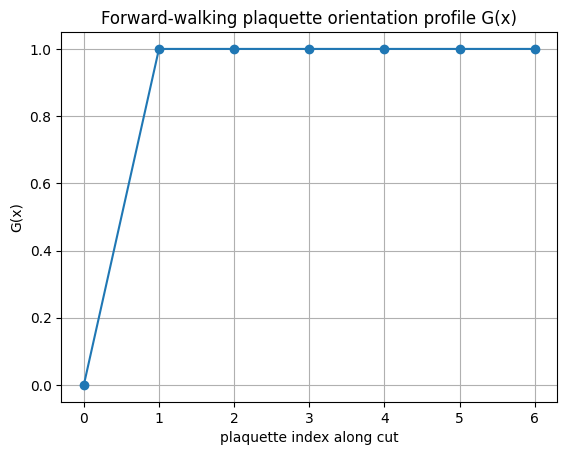

In [10]:
# ------------------------ main ------------------------ #

if __name__ == "__main__":
    data = lgfmc()
    print("GFMC run finished.")
    print("O shape:", data["O"].shape)

    Gx = forward_walking_fwalk(data, L=20, N=20)
    print("Forward-walking G(x) shape:", Gx.shape)
    print("G(x):", Gx)

    import matplotlib.pyplot as plt

    k = data["k"]
    x_sites = np.arange(2 * k - 1)

    plt.figure()
    plt.plot(x_sites, Gx, marker="o")
    plt.xlabel("plaquette index along cut")
    plt.ylabel("G(x)")
    plt.title("Forward-walking plaquette orientation profile G(x)")
    plt.grid(True)
    plt.show()
